# 结果展示

In [29]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
import os

from utils import config
from utils.backtest import *

start_date = config.End_Trade_Date.replace("-", "")
end_date = config.End_Test_Date.replace("-", "")

## 数据读取

In [30]:
root_path = os.getcwd()
root_path = os.path.join(root_path, "learn", "trade_file")
print("root_path: ", root_path)

root_path:  /home/david/MF/github/StockRL/learn/trade_file


In [31]:
model_list = ["a2c", "ppo", "td3", "ddpg", "sac"]
path_dict = {}
for model in model_list:
    path_dict[model] = os.path.join(root_path, "account_value_{}.csv".format(model))

In [32]:
account_value_dict = {}
for m in model_list:
    account_value_dict[m] = pd.read_csv(path_dict[m])

## 获取 baseline 的结果

In [33]:
get_baseline_func = lambda: get_baseline(config.SSE_50_INDEX, 
              start=start_date,
              end=end_date)
baseline_csv_file = root_path + os.sep + "baseline_sse50.csv"
baseline_df = get_baseline_from_file(baseline_csv_file, get_baseline_func)

In [34]:
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

Annual return         -0.117414
Cumulative returns    -0.113029
Annual volatility      0.130011
Sharpe ratio          -0.899786
Calmar ratio          -0.547896
Stability              0.847976
Max drawdown          -0.214301
Omega ratio            0.863667
Sortino ratio         -1.275702
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.026249
Daily value at risk   -0.016844
dtype: float64


In [35]:
start_close_value = baseline_df.iloc[0]['close']
baseline_df['processed_close'] = ((baseline_df['close'] - start_close_value)/start_close_value + 1) * 1e+6

In [36]:
baseline_df.head()

,tic,date,open,high,low,close,volume,day,processed_close
0,000016.SH,2023-01-03,2641.4218,2628.6723,2645.9915,2603.7234,30230100.0,1,1.000000e+06
1,000016.SH,2023-01-04,2651.0050,2644.2910,2659.5351,2637.7160,28065521.0,2,1.013055e+06
2,000016.SH,2023-01-05,2700.3082,2670.4576,2705.7388,2668.1451,27714894.0,3,1.024742e+06
3,000016.SH,2023-01-06,2713.6307,2704.2375,2721.9279,2698.9087,28367259.0,4,1.036557e+06
4,000016.SH,2023-01-09,2742.2014,2730.9952,2747.6106,2722.1459,29682897.0,0,1.045482e+06


## 展示最终的结果

In [37]:
data = {
    m: account_value_dict[m]['total_assets'] for m in model_list
}
data['baseline'] = baseline_df['processed_close']
result_account_value = pd.DataFrame(data = data)

In [38]:
result_account_value = result_account_value.iloc[:-1].apply(lambda x : (x - 1e+6)/1e+6)

In [39]:
result_account_value.tail()

,a2c,ppo,td3,ddpg,sac,baseline
236,-0.185164,-0.165660,-0.043187,0.034077,-0.029129,-0.135298
237,-0.184755,-0.165644,-0.041345,0.033945,-0.029168,-0.130628
238,-0.191093,-0.171487,-0.043544,0.028122,-0.038447,-0.133797
239,-0.189558,-0.170071,-0.044047,0.031753,-0.035077,-0.135847
240,-0.172202,-0.153603,-0.027240,0.046481,-0.011303,-0.130002


In [40]:
result_account_value.to_csv(os.path.join(root_path, "result_account_value.csv"), index=False)

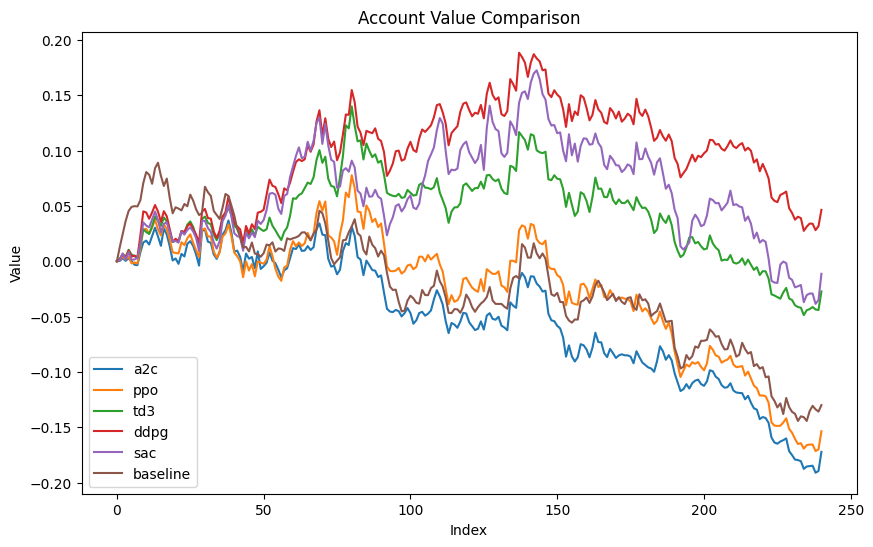

In [41]:
plt.figure(figsize=(10, 6))
for col in result_account_value.columns:
    plt.plot(result_account_value.index, result_account_value[col], label=col)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Account Value Comparison')
plt.legend()
plt.show()

## 展示回测结果

In [42]:
print("和 {} 指数进行比较".format(config.SSE_50_INDEX[0]))
cmp_data = backtest_plot_from_file(baseline_csv_file, get_baseline_func, 
                        account_value_dict,
                        value_col_name = 'total_assets')
df = pd.DataFrame(cmp_data).T
df

和 000016.SH 指数进行比较


,累计收益率,最大回撤率,年化收益率,年化波动率,Sharpe比率,Omega比率
baseline,-11.30%,-21.43%,-11.74%,12.97%,-90.50%,86.37%
a2c,-17.22%,-21.99%,-17.93%,13.04%,-137.52%,78.63%
ppo,-15.36%,-23.13%,-16.00%,14.45%,-110.71%,82.62%
td3,-2.72%,-16.54%,-2.85%,12.76%,-22.31%,97.28%
ddpg,4.65%,-13.55%,4.87%,13.96%,34.85%,106.79%
sac,-1.13%,-18.00%,-1.18%,16.13%,-7.33%,100.10%
